# Multiplexed Qubit Readout with UHFQA

Copyright (C) 2020 Zurich Instruments

This software may be modified and distributed under the terms
of the MIT license. See the LICENSE file for details.

## Table of Content:
* [Helper Functions](#helper-functions)
* [Initialization](#initialization)
* [Multiplexed readout of superconducting qubits](#multiplexed-readout)
* [Single qubit measurement](#single-qubit)
* [Optimal integration weights](#optimal-weights)
* [Multiplexed readout with optimal integration weigths](#multiplexed-optimal-weights)
* [Crosstalk Calibration](#crosstalk-calibration)
* [State Discrimiation](#state-discrimination)
    * [How good is the discriminator?](#discriminator-evaluation)
    * [Single-shot readout](#single-shot-readout)
    * [Cross-assignment](#cross-assignment)

In [1]:
import zhinst.ziPython as zi

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import itertools

## Helper functions in `multiplexed_readout_helpers.py`: <a class="anchor" id="helper-functions"></a>

Some functionality of this example has been moved to `multiplexed_readout_helpers.py` in order to keep this notebook more clear. There is no magic involved, just check the function definitions in the file.

In [3]:
from multiplexed_readout_helpers import *

____

* `sequence_multiplexed_readout(channels, frequencies, n_averages, state=None):`

    Returns an AWG sequence program (`String`) that specifies the sequence for multiplexed readout. Amplitudes and phases are hardcoded in the function for up to 10 channels and for ground and excited qubit states (*simulated* response of a readout resonator for qubit in either ground or excited state).
   
    * **arguments:**
    
        * `channels` list of channels to create readout pulse for, integers that specify index of channel to be used for frequencies, amplitudes, phases
        * `frequencies` list of frequencies (in Hz) for readout pulses
        * `n_averages` integer number that specifies number of repetitions
        * `state` list of 0/1 s, states of measured channels to be simulated

>```python
>...
>if state[i]:
>    amplitudes[ch] = amplitudes[ch] * (1 + deltas_amplitude[ch])
>    phases[ch] += deltas_phase[ch]
>
>awg_program_init = textwrap.dedent(
>    """\
>    const samplingRate = 1.8e9;
>    // parameters for envelope
>    const riseTime = 10e-9;
>...
>```

____


* `compile_sequence(awg_module, awg_program):`

    Starts compilation of AWG sequence program and loads it to device.
    
    * **arguments:**

        * `awg_module` awgModule object
        * `awg_program` String that specifies the awg sequence in `.seqC` format
    
>```python
>...
>awg_module.set("compiler/sourcestring", awg_program)
>...
>```

____



* `run_awg(daq, device)`:

    Runs AWG sequence. The function sets the AWG to single shots (as opposed to continuous) and eables the AWG.

    * **arguments:**
        * `daq` is a `zhinst.ziDAQServer` data server object
        * `device` serial number, e.g. "dev2266"

    
>```python
>...
>daq.syncSetInt("/{:s}/awgs/0/enable".format(device_id), 1)
>...
>```

____


* `toggle_outputs(daq, device, channel=None)`:

    Toggles the signal outputs of the UHFQA.
    
    * **arguments:**
    
        * `daq` is a `zhinst.ziDAQServer` data server object
        * `device` serial number, e.g. "dev2266"
        * `channel` index of channel to be switched, if not specified defaults to both


____



* `set_integration_weights(daq, device, weights, channel, quadrature="real", demod_frequency=None):`

    Sets the integration weights of the UHFQA. The input signals are multiplied with the integration weights for each channel.
    
    * **arguments:**
    
        * `daq` is a `zhinst.ziDAQServer` data server object
        * `device` serial number, e.g. "dev2266"
        * `weights` list that specifies the integation weights, has to be normalized
        * `channel` index of channel whose weights should be set
        * `quadrature` specifies if real or imaginary weights of channel are set
        * `demod_frequency` if specified, the integration weights are multiplied by a sine wave at the demodulation frequency for digital demodulation of the signal

____


* `reset_integration_weights(daq, device, channels=range(10)):`

    Resets the integration weights of the UHFQA to all zeros.
    
    * **arguments:**
    
        * `daq` is a `zhinst.ziDAQServer` data server object
        * `device` serial number, e.g. "dev2266"
        * `channels` list of index of channel whose integration weights should be reset, defaults to `range(10)`
        

____



* `set_qa_results(daq, device, result_length, result_averages, source="integration"):`
    
    Applies settings to the QA Results tab.
    
    * **arguments:**
    
        * `daq` is a `zhinst.ziDAQServer` data server object
        * `device` serial number, e.g. "dev2266"
        * `result_length` integer that specifies the number of samples to be recorded
        * `result_averages` integer that specifies the number of averages for one result sample
        * `source` String that specifies the source of the result data, defaults to `"integration"`

____



* `set_qa_monitor(daq, device, monitor_length, averages):`

    Applies settings to the QA Monitor tab.
    
    * **arguments:**
    
        * `daq` is a `zhinst.ziDAQServer` data server object
        * `device` serial number, e.g. "dev2266"
        * `monitor_length` integer that specifies the number of samples to be recorded
        * `averages` integer that specifies the number of averages
        

____


* `write_crosstalk_matrix(daq, device, matrix):`
    Writes the given matrix to the QA Setup crosstalk matrix of the UHFQA.

    * **arguments:**

        * `daq` is a `zhinst.ziDAQServer` data server object
        * `device` serial number, e.g. "dev2266"
        * `matrix` is a crosstalk matrix to be written to the QA Setup tab

____



* `optimal_integration_weights(daq, device, awg, channel, frequencies, plot=False, delay=None):`

    Sets the optimal integration weights for specified channel. Measures IQ traces for channel being in ground/excited state and takes difference as optimal weights, i.e.

    * **arguments:**
    
        * `daq` is a `zhinst.ziDAQServer` data server object
        * `device` serial number, e.g. "dev2266"
        * `awg` awgModule object
        * `channel` index of channel 
        * `frequencies` list of frequencies of readout pulses for all channels
        * `plot` bool that specifies is plots should be displayed
        * `delay` integer, number of samples at beginning of integration weights that should be set to zero, i.e. before pulse is measured, i.e.

>```python
>...
>weights_I = wave_I_1 - wave_I_0
>weights_Q = wave_Q_1 - wave_Q_0
>weights_I = weights_I / np.max(np.abs(weights_I))
>weights_Q = weights_Q / np.max(np.abs(weights_Q))
>...
>```
       
       
* `acquisition_poll(daq, paths, num_samples, timeout=10.0)`

    Polls the UHFQA for data. Taken from `zhinst.examples.uhfqa.common`.

    * **arguments:**
    
        * `daq` is a `zhinst.ziDAQServer` data server object
        * `paths` list of subscribed paths
        * `num_samples` expected number of samples
        * `timeout` time in seconds before timeout Error is raised.
____




# Initialization <a class="anchor" id="initialization"></a>
* connect to LabOne Data Server using `ziDAQServer`
* connect to device (using ethernet)


In [4]:
# connect to LabOne Data Server
device = 'dev2266'

discovery = zi.ziDiscovery()
device_id = discovery.find(device)
device_props = discovery.get(device_id)

daq = zi.ziDAQServer(device_props['serveraddress'],     # host
                     device_props['serverport'],        # port
                     device_props['apilevel'])          # API level

# connect device to Data Server
daq.connectDevice(device, '1GbE')

* create AWG Module object
* set device and start the module with  `.execute()`

In [5]:
# create AWG Module
awg = daq.awgModule()
awg.set('device', device)
awg.execute()

* make sure outputs are turned on

In [8]:
# make sure outputs are on
toggle_outputs(daq, device)

# Multiplexed readout of superconducting qubits <a class="anchor" id="multiplexed-readout"></a>

This is the main topic of this notebook. We want to demonstrate how to implement multiplexed readout of up to 10 superconducting qubits using a single UHFQA device. Readout of superconducting qubits relies on the measurement of microwave resonators that are dispersively coupled to a superconducting qubit. The resonators show a small shift in their resonance frequency dependent on the qubit state. This dispersive shift can be measured for up to 10 resonators at once using the Zurich Instruments UHFQA which also offers advanced tools analyze the acquired readout signal.

This notebook serves as a demonstration of the UHFQA device functionalities without the need for actual physical qubits to be controlled and measured. For the demonstration a simple closed loop from outputs to inputs is sufficient. The state dependent response of the readout resonators is simulated by sending a readout pulse with a slightly different amplitude and phase at the respective frequency.

Necessary parameters to be defined for multiplexed readout are:
* number of readout channels, i.e. `n_channels`
* readout frequencies 
* readout amplitudes 

In [9]:
frequencies = 1e6 * np.linspace(82.6, 119.7, 10)
n_channels = 5 #len(frequencies)

* the variable `monitor_length` is the number of samples to be recorded in the **Quantum Analyzer Input** tab
* `monitor_averages` is the number of averages used for the recorded input data

In [10]:
monitor_length = 700   # has to be multiple of 4
monitor_averages = 2**10

# Single qubit measurement <a class="anchor" id="single-qubit"></a>

We first want to demonstrate simple single qubit measurements with the UHFQA. For this purpose, we apply settings to the **Quantum Analyzer Results** tab with the specified number of samples (`result_length = 100`) and averages (`result_averages = 1`). We want the results to be taken right after the `'integration'` step where they are complex values.

For each individual channel we perform the following steps:

* define the path `'.../result/data/{channel}/wave'` used to poll the result data from the data server


* set the integration weights for real and imaginary parts of the corresponding channel
   
   - we use the helper function `set_integration_weights()` with constant integration weights
   
   - the parameter `demod_frequency` multiplies the weigths with a sine wave at the demodulation frequency to achieve digital demodulation (if this parameter is not specified this is omittted)  
   

* define ground and excited state as lists of zeros and ones (first for only one channel)


* for each state we create an AWG sequence program using `sequence_multiplexed_readout()`, the function assembles the `.seqC` file from predefined text blocks. The sequence takes into account the defined channels, readout frequencies and number of repetitions (set to be the product of result samples and averages)

    The `sequence_multiplexed_readout()` function also has a `state` parameter. This parameter tells the function for which of the specified channels to modify the readout pulse in order to *simulate* an excited state of the qubit. For the purpose of this example, this small change of the readout signal serves as an artificial dispersive shift due to the measured qubit being in its excited state.  
    
    
* next, the `compile_sequence()` function compiles the AWG sequence program and loads it to the device


* we sync the device, subscribe to the previously specified path 


* finally, we tell the AWG to play the waveform with the `run_AWG()` function, the result is polled from the data server and appended to a list that stores the data 

In order to demonstrate a simple measurement, we now want to measure each qubit individually (i.e. not multiplexed) in its ground ($|0>$) and excited state ($|1>$). We call the function `sequence_multiplexed_readout()` with only a single entry in the list `channels` such that the readout pulse contains only a single frequency. The function parameter `state` is given either as the ground state (`[0]`) or the excited state (`[1]`). 

In [11]:
result_length = 100
result_averages = 1

# initialize QA Monitor and Results tab
set_qa_results(daq, device, result_length, result_averages, source='integration')
set_qa_monitor(daq, device, monitor_length, monitor_averages)

result_list = []
for channel in range(n_channels):
    
    # path to result data for single channel
    result_path = [f'/{device}/qas/0/result/data/{channel}/wave']

    # set integration weights 
    reset_integration_weights(daq, device) 
    set_integration_weights(daq, device, np.ones(2000), channel, quadrature='real', demod_frequency=frequencies[channel])
    set_integration_weights(daq, device, np.ones(2000), channel, quadrature='imag', demod_frequency=frequencies[channel])
    
    # define states
    ground_state = [0]
    excited_state = [1]
    
    # iterate over ground/excited state
    for state in [ground_state, excited_state]: 
        print(f"Channel {channel} in state: |{','.join(str(num) for num in state)}>")
        
        # create sequence program, compile and send to AWG
        awg_program = sequence_multiplexed_readout(
            [channel],  
            frequencies, 
            result_length*result_averages,
            state=state
        )
        compile_sequence(awg, awg_program)
        
        # sync device, subscribe to path and run AWG
        daq.sync()
        time.sleep(0.1)
        daq.subscribe(result_path)
        run_awg(daq, device)
        
        # poll data from DAQ
        result_list.append(acquisition_poll(daq, result_path, result_length))
        print('\t\t\t--> Data acquired')
        daq.unsubscribe(result_path)

print('\n*** Finished ***')

Channel 0 in state: |0>
			--> Data acquired
Channel 0 in state: |1>
			--> Data acquired
Channel 1 in state: |0>
			--> Data acquired
Channel 1 in state: |1>
			--> Data acquired
Channel 2 in state: |0>
			--> Data acquired
Channel 2 in state: |1>
			--> Data acquired
Channel 3 in state: |0>
			--> Data acquired
Channel 3 in state: |1>
			--> Data acquired
Channel 4 in state: |0>
			--> Data acquired
Channel 4 in state: |1>
			--> Data acquired

*** Finished ***


Because we specified the data source as after the integration step, the polled data is complex and can be displayed in the I/Q-plane. The demodulated readout pulse corresponds to a cloud of points in the IQ-plane. 

We want to plot the measured data of each channel for the qubit being in its (simulated) ground or excited state. For the excited state a slightly different phase and amplitude of the pulse is used. This recreates the response of a readout resonator dispersively coupled to a superconducting qubit. Because of the qubit state dependent dispersive shift of the resonator frequency, a readout pulse at a fixed frequency close to the resonance experiences a small change of its amplitude and phase depending on the state of the qubit.

The acquired signals show two separated point clouds for each measurement channel that are used to discriminate the state of the associated qubit. 

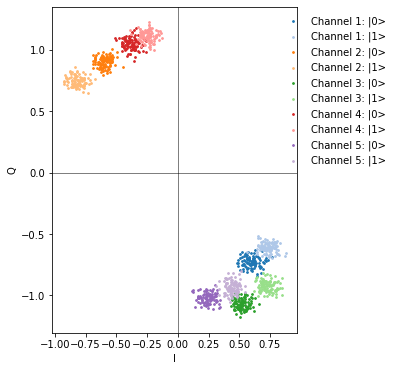

In [12]:
# plot the acquired data in IQ plane
fig, ax = plt.subplots(figsize=[8, 6])
ax.set_aspect('equal')
ax.axhline(0, c='k', linewidth=0.5)
ax.axvline(0, c='k', linewidth=0.5)
ax.set_xlabel('I')
ax.set_ylabel('Q')
        
# iterate over channels and ground/excited state
for channel in range(n_channels): 
    for excited in [0, 1]:
        index = 2*channel + excited
        result = result_list[index]
        data = list(result.values())[0]
        label = f'Channel {channel+1}: |{str(excited)}>'
        ax.scatter(np.real(data), np.imag(data), s=3, color=plt.cm.tab20(index), 
                    label=label) 
    
ax.legend(frameon=False, bbox_to_anchor=[1.4, 1.0])
plt.show()

# Optimal integration weights <a class="anchor" id="optimal-weights"></a>

We employ a simple method to obtain integration weights with optimal signal-to-noise ratio (SNR): the measured I and Q traces (before demodulation) are recorded for both the qubit being in its ground and excited state. Simply the averaged difference between the two traces gives the optimal integration weights for the I and Q channel respectively. 

$$ w_I = < V_{I, e} - V_{I, g} >$$
$$ w_Q = < V_{Q, e} - V_{Q, g} >$$

Because we use the signal before modulation, the difference of the traces already contains the integration weights to perform demodulation. This way, there is no more need to multiply the integrtion weights with a sine wave at the demodulation frequency.  

Here, we first apply the initial settings to the QA monitor tab. Then we call the function `optimal_integration_weights()` for each channel individually. The function performs a measurement with the specified channel being in the ground and excited state and records the two input signals (I and Q trace) as displayed in the monitor tab. The function calculates the difference of the traces and sets the integration weights accordingly. 

Channel 0 in state |0>
		--> Data acquired
Channel 0 in state |1>
		--> Data acquired


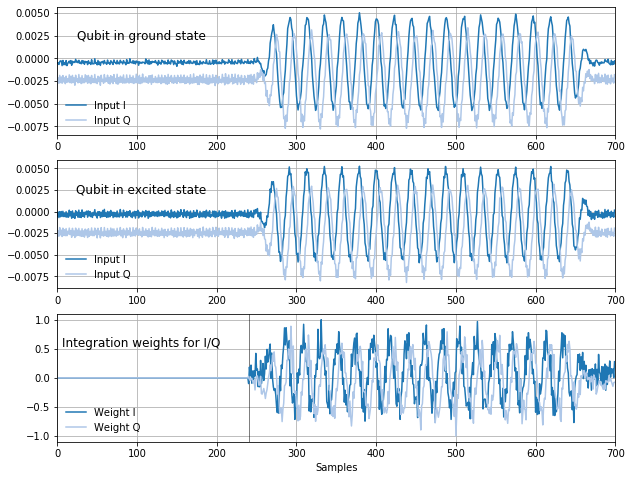

Channel 1 in state |0>
		--> Data acquired
Channel 1 in state |1>
		--> Data acquired


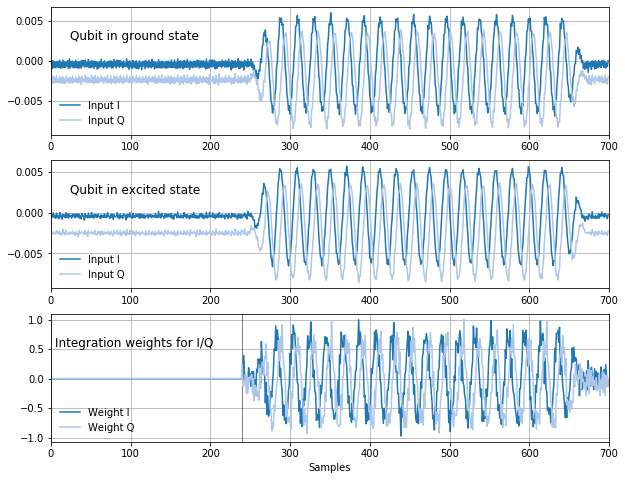

Channel 2 in state |0>
		--> Data acquired
Channel 2 in state |1>
		--> Data acquired


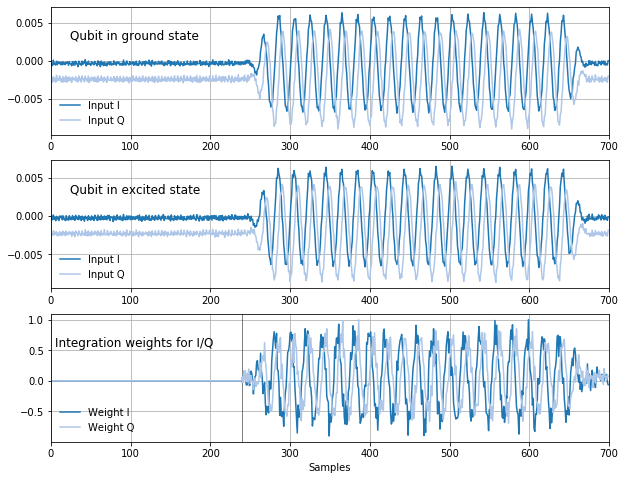

Channel 3 in state |0>
		--> Data acquired
Channel 3 in state |1>
		--> Data acquired


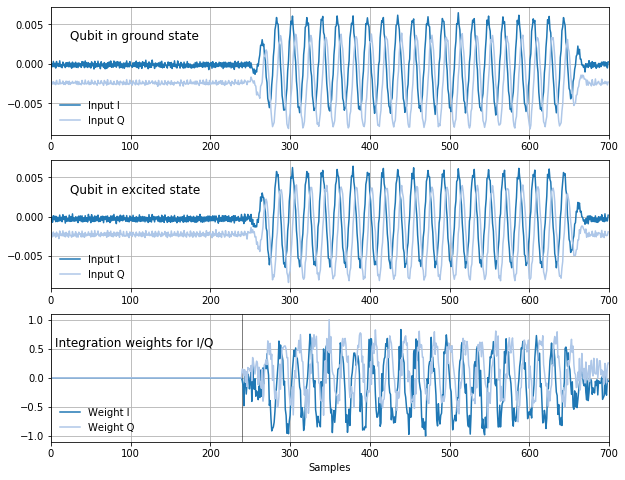

Channel 4 in state |0>
		--> Data acquired
Channel 4 in state |1>
		--> Data acquired


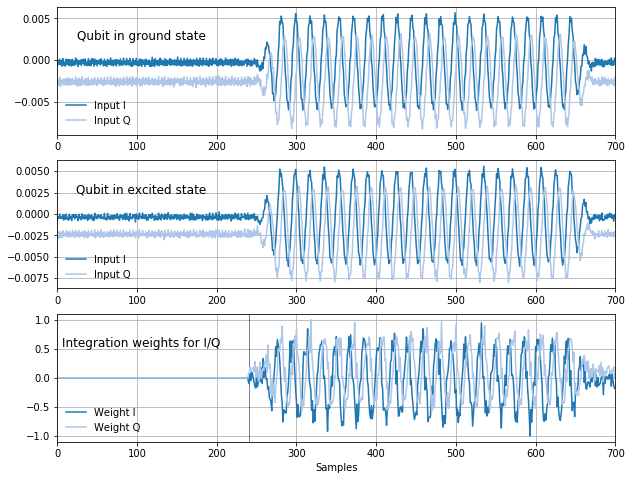


*** Finished ***


In [13]:
set_qa_monitor(daq, device, monitor_length, monitor_averages)

for channel in range(n_channels):
    optimal_integration_weights(daq, 
                                device,
                                awg,
                                channel,
                                frequencies,
                                plot=True, 
                                delay=240)

print('\n*** Finished ***')

# Multiplexed readout with optimal integration weights <a class="anchor" id="multiplexed-optimal-weights"></a>

Now that we have set the optimal integration weigths for each channel, we move on to **multiplexed** qubit readout. This means that we *simultaneously* read out the state of all qubit channels. To this end, we sum up the readout pulses at different frequencies into a single pulse. This is done in the `sequence_multiplexed_readout()` function, specifying the used channels and the prepared state. 

The QA module measures the I and Q sinals of the pulse at the two inputs. For each of the up to ten measurement channels, the I and Q signal is multiplied with the stored integration weights and is converted to a complex signal. 

In the following cell we create a readout pulse for `n_channel` qubits. We record the measurement result of the QA after the integration step for a single qubit either being in the ground or excited state. All other qubits are set to be in the ground state. We store the IQ-traces in the lists `tracesIQ_ground` and `tracesIQ_excited` which will be used to plot the data in the next cell.

In [14]:
result_length = 100
result_averages = 1

tracesIQ_ground = []
tracesIQ_excited = []

# update QA Results settigs, use data right after the integration step of the QA
set_qa_results(daq, device, result_length, result_averages, source='integration')

# iterate over all channels
for channel in range(n_channels):
    # path to result data for single channel
    result_path = [f'/{device}/qas/0/result/data/{channel}/wave']
    result_list = []
    
    print(f'\nChannel {channel}:')

    # define ground and excited state for all qubits
    ground_state = [0] * n_channels
    excited_state = [0] * n_channels
    excited_state[channel] = 1
    
    # iterate over ground/excited state
    for state in [ground_state, excited_state]: 
        print(f' - state: |{",".join(str(num) for num in state)}>')
        
        # create awg sequence program, compile and send to AWG
        awg_program = sequence_multiplexed_readout(
            range(n_channels),  
            frequencies, 
            result_length*result_averages, 
            state=state
        )
        compile_sequence(awg, awg_program)

        # sync device, subscribe to path and run AWG
        daq.sync()
        time.sleep(0.1)
        daq.subscribe(result_path)
        run_awg(daq, device)

        # poll data from DAQ
        result_list.append(acquisition_poll(daq, result_path, result_length))
        print('\t\t\t--> Data acquired')
        daq.unsubscribe(result_path)

    # store data in separate lists
    for i, result in enumerate(result_list):
        if i%2 == 0: 
            tracesIQ_ground.append(list(result.values())[0])
        if i%2 == 1: 
            tracesIQ_excited.append(list(result.values())[0])

print('\n*** Finished ***')


Channel 0:
 - state: |0,0,0,0,0>
			--> Data acquired
 - state: |1,0,0,0,0>
			--> Data acquired

Channel 1:
 - state: |0,0,0,0,0>
			--> Data acquired
 - state: |0,1,0,0,0>
			--> Data acquired

Channel 2:
 - state: |0,0,0,0,0>
			--> Data acquired
 - state: |0,0,1,0,0>
			--> Data acquired

Channel 3:
 - state: |0,0,0,0,0>
			--> Data acquired
 - state: |0,0,0,1,0>
			--> Data acquired

Channel 4:
 - state: |0,0,0,0,0>
			--> Data acquired
 - state: |0,0,0,0,1>
			--> Data acquired

*** Finished ***


In this cell we simply plot the acquired point clouds in the IQ-plane for each measured channel. We see two separated clouds that were measured for the qubit either being in its ground or excited state. We plot the raw data on the left panel and indicate the center of gravity of each cloud by a red dot. 

After setting the optimal weights, the clouds are now arranged such that their separation in the I and Q quadratures are equal, implying that the angle of the line through their centers is at roughly 45°. We can calculate this angle from the centers of the point clouds. If we rotate the data in the IQ-plane by this angle (right plots), the entire signal is brought to the I quadrature. The vertical red line indicates a simple linear separator with a threshold in the I quadrature of the signal that is calculated from the centers of the point clouds.

We can use the calculated rotation angle for the processing of the complex data and set the rotation in the **Quantum Analyzer Setup** tab to the obtained value. The full readout signal of each channel is now contained in the signal after the rotation step in the QA. 

Setting rotation of channel 0 to: 42.93494115297361 deg


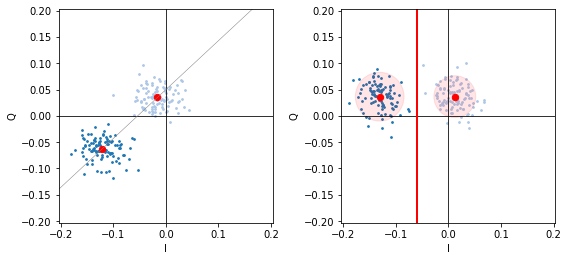

Setting rotation of channel 1 to: 48.61160892040167 deg


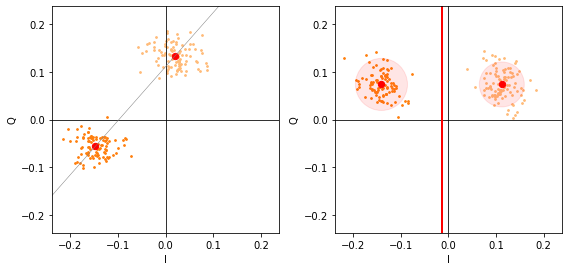

Setting rotation of channel 2 to: 41.60362747389239 deg


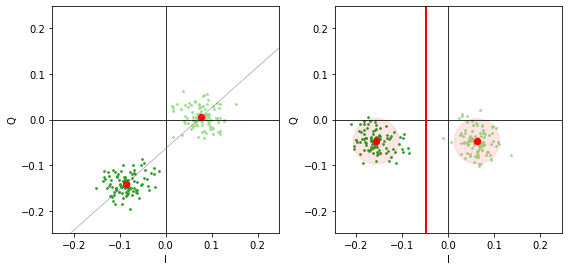

Setting rotation of channel 3 to: 38.6131226226158 deg


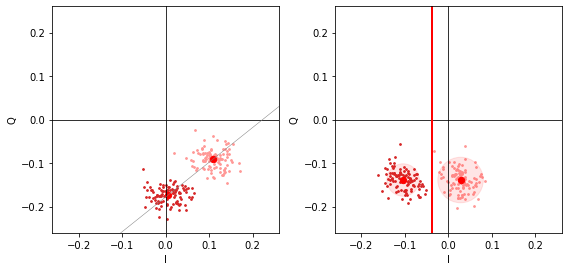

Setting rotation of channel 4 to: 43.2369673291926 deg


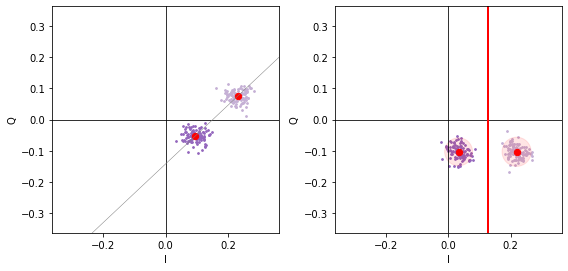

Thresholds:
*	-0.06
*	-0.01
*	-0.05
*	-0.04
*	0.13


In [18]:
thresholds = []

for i in range(n_channels):

    trace_ground = tracesIQ_ground[i]
    trace_excited = tracesIQ_excited[i]
    
    center_ground = np.mean(trace_ground)
    center_excited = np.mean(trace_excited)
    
    difference = center_excited - center_ground
    angle = np.angle(difference)
    
    print(f'Setting rotation of channel {i} to: {180*angle/np.pi} deg')
    daq.setComplex(f'/{device}/qas/0/rotations/{i}', np.exp(-1j * angle))

    x = np.linspace(-2, 2, 10)
    line = np.tan(angle)*(x-np.real(center_ground)) + np.imag(center_ground)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[8, 4], tight_layout=True)
    ax1.set_aspect('equal')
    ax2.set_aspect('equal')
    scale = 1.5 * np.max([np.abs(center_excited), np.abs(center_ground)])
    
    ax1.axhline(0, c='k', linewidth=0.8)
    ax1.axvline(0, c='k', linewidth=0.8)
    ax1.plot(x, line, c='grey', linewidth=0.5)
    ax1.scatter(np.real(trace_ground), np.imag(trace_ground), s=3, color=plt.cm.tab20(2*i))
    ax1.scatter(np.real(trace_excited), np.imag(trace_excited), s=3, color=plt.cm.tab20(2*i+1))
    ax1.scatter(np.real(center_ground), np.imag(center_ground), c='red', s=40)
    ax1.scatter(np.real(center_excited), np.imag(center_excited), c='red', s=40)
    ax1.set_xlim([-scale, scale])
    ax1.set_ylim([-scale, scale])
    
    ax2.axhline(0, c='k', linewidth=0.8)
    ax2.axvline(0, c='k', linewidth=0.8)
    th = np.mean([trace_excited*np.exp(-1j*angle), trace_ground*np.exp(-1j*angle)])
    ax2.axvline(th, c='red', linewidth=2)
    ax2.scatter(np.real(trace_ground*np.exp(-1j*angle)), np.imag(trace_ground*np.exp(-1j*angle)), s=3, color=plt.cm.tab20(2*i))
    ax2.scatter(np.real(trace_excited*np.exp(-1j*angle)), np.imag(trace_excited*np.exp(-1j*angle)), s=3, color=plt.cm.tab20(2*i+1))
    ax2.scatter(np.real(center_ground*np.exp(-1j*angle)), np.imag(center_ground*np.exp(-1j*angle)), c='red', s=40)
    ax2.scatter(np.real(center_excited*np.exp(-1j*angle)), np.imag(center_excited*np.exp(-1j*angle)), c='red', s=40)
    radius1 = 2 * np.std(np.abs(trace_ground*np.exp(-1j*angle)))
    radius2 = 2 * np.std(np.abs(trace_excited*np.exp(-1j*angle)))
    ax2.add_patch(plt.Circle((np.real(center_ground*np.exp(-1j*angle)), np.imag(center_ground*np.exp(-1j*angle))), radius1, color='r', alpha=0.1))
    ax2.add_patch(plt.Circle((np.real(center_excited*np.exp(-1j*angle)), np.imag(center_excited*np.exp(-1j*angle))), radius2, color='r', alpha=0.1))
    ax2.set_xlim([-scale, scale])
    ax2.set_ylim([-scale, scale])
    
    ax1.set_xlabel('I')
    ax1.set_ylabel('Q')
    ax2.set_xlabel('I')
    ax2.set_ylabel('Q')
    plt.show()
    
    thresholds.append(np.real(th))
    
print("Thresholds:")
for t in thresholds:
    print("*\t{:.2f}".format(t))

## Crosstalk Calibration <a class="anchor" id="crosstalk-calibration"></a>

One important feature of the UHFQA is the possibility to compensate signal crosstalk directly on the device using the built in crosstalk compensation matrix. The presence of crosstalk in the readout chain implies that a state change of only one qubit not only affects the measured signal of the corresponding channel but also changes the signal of other channels. This could for example be due to crosstalk between readout resonators and qubits on the device itself. Another source of crosstalk is spectral overlap of the readout signals between different channels. This is especially the case when the readout frequencies are close together and when pulses are short. In this demonstration we can easily observe crosstalk from spectral overlap when we place the readout frequencies close together.

The crosstalk matrix $M$ is the matrix that transforms a multi-qubit state $(s_1, s_2, ..., s_{10})$ with $s_q = 0$ or $1$, e.g. $s_1 = (1, 0, ..., 0)$, into a signal vector of voltages $(V_1, V_2, ..., V_{10})$. It is measured when the crosstalk matrix is either bypassed or set to the identity. Unwanted crosstalk can be suppressed by finding the matrix $C$ that diagonalizes $C \times M$. 

In order to calibrate crosstalk suppression we first measure $M$ and eventually set the crosstalk compensation matrix in the **Quantum Analyzer Setup** tab to be $C = M^{-1}$. 

In [19]:
# make sure crosstalk matrix is the set to the identity
write_crosstalk_matrix(daq, device, np.eye(10))

In [20]:
result_length = 10000
result_averages = 256

# data source has to be after the crosstalk unit
set_qa_results(daq, device, result_length, result_averages, source='crosstalk')

result_paths = []
for ch in range(n_channels):
    result_paths.append(f'/{device}/qas/0/result/data/{ch}/wave')

# excite one qubit and measure influence on all readout channels
combinations = [np.zeros(n_channels, dtype=int)]
for n in range(n_channels):
    state = np.zeros(n_channels, dtype=int)
    state[n] = int(1)
    combinations.append(state)    
    
# measurement
result_list = []
for state in combinations:
    print(f' - state: |{",".join(str(num) for num in state)}>')
    
    # set up AWG sequence program
    awg_program = sequence_multiplexed_readout(
        range(n_channels),  
        frequencies, 
        result_length*result_averages, 
        state=state
    )
    compile_sequence(awg, awg_program)

    # ensure all settings are synced and subscribe to data path(s)
    daq.sync()
    time.sleep(0.1)
    daq.subscribe(result_paths)

    # run AWG sequence and start acquisition
    run_awg(daq, device)

    # poll data
    result_list.append(acquisition_poll(daq, result_paths, result_length))
    print('\t\t--> Data acquired')
    daq.unsubscribe(result_paths)

print('\n*** Finished ***')

 - state: |0,0,0,0,0>
		--> Data acquired
 - state: |1,0,0,0,0>
		--> Data acquired
 - state: |0,1,0,0,0>
		--> Data acquired
 - state: |0,0,1,0,0>
		--> Data acquired
 - state: |0,0,0,1,0>
		--> Data acquired
 - state: |0,0,0,0,1>
		--> Data acquired

*** Finished ***


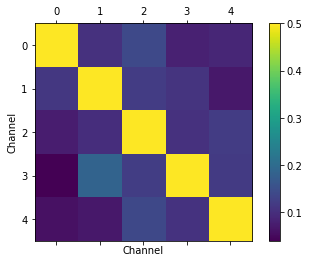

Total Crosstalk: 2.0776


In [21]:
# assemble matrix and plot
ct_matrix = np.zeros([n_channels, n_channels])
reference = list(result_list[0].values())

for row, result in enumerate(result_list[1:]):
    result = list(result.values())
    for column in range(n_channels):
        signal = result[column] - reference[column]
        ct_matrix[row, column] = np.mean(signal)
        
for r in range(n_channels):
    ct_matrix[r,:] = ct_matrix[r,:] / ct_matrix[r,r]
    
fig, ax = plt.subplots(figsize=[6, 4])
cax = ax.matshow(np.abs(ct_matrix), vmax=0.5)
fig.colorbar(cax)
ax.set_xlabel("Channel")
ax.set_ylabel("Channel")
plt.show()

print("Total Crosstalk: {:.5}".format(np.sum(np.abs(ct_matrix))-n_channels))

- in order to compensate the measured crosstalk we invert the crosstalk matrix
- we use `np.linalg.inv(ct_matrix)` and write the matrix for the `n_channels` channels

In [22]:
np.linalg.inv(ct_matrix)

array([[ 1.04950718,  0.16736599,  0.20677788, -0.14207164,  0.14756212],
       [ 0.15144094,  1.07418996,  0.18894677, -0.16342327,  0.1296656 ],
       [ 0.11815405,  0.16234945,  1.0798989 , -0.15998797,  0.17224926],
       [-0.09596862, -0.24189462, -0.1989288 ,  1.0742046 , -0.17605349],
       [ 0.10068123,  0.13330292,  0.19746061, -0.15786932,  1.06086082]])

In [23]:
write_crosstalk_matrix(daq, device, np.linalg.inv(ct_matrix))

In [24]:
result_length = 10000
result_averages = 128

# data source has to be after the crosstalk unit
set_qa_results(daq, device, result_length, result_averages, source='crosstalk')

result_paths = []
for ch in range(n_channels):
    result_paths.append(f'/{device}/qas/0/result/data/{ch}/wave')

# excite one qubit and measure influence on all readout channels
combinations = [np.zeros(n_channels, dtype=int)]
for n in range(n_channels):
    state = np.zeros(n_channels, dtype=int)
    state[n] = int(1)
    combinations.append(state)    

# measurement
result_list = []
for state in combinations:
    print(f' - state: |{",".join(str(num) for num in state)}>')
    
    # set up AWG sequence program
    awg_program = sequence_multiplexed_readout(
        range(n_channels),  
        frequencies, 
        result_length*result_averages, 
        state=state
    )
    compile_sequence(awg, awg_program)

    # ensure all settings are synced and subscribe to data path(s)
    daq.sync()
    time.sleep(0.1)
    daq.subscribe(result_paths)

    # run AWG sequence and start acquisition
    run_awg(daq, device)

    # poll data
    result_list.append(acquisition_poll(daq, result_paths, result_length))
    print('\t\t--> Data acquired')
    daq.unsubscribe(result_paths)

print('\n*** Finished ***')

 - state: |0,0,0,0,0>
		--> Data acquired
 - state: |1,0,0,0,0>
		--> Data acquired
 - state: |0,1,0,0,0>
		--> Data acquired
 - state: |0,0,1,0,0>
		--> Data acquired
 - state: |0,0,0,1,0>
		--> Data acquired
 - state: |0,0,0,0,1>
		--> Data acquired

*** Finished ***


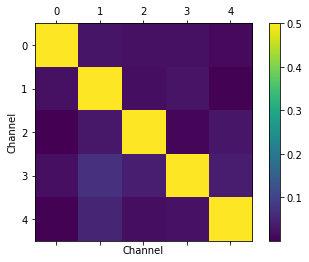

Total Crosstalk: 0.50499


In [25]:
# assemble matrix and plot it
ct_matrix = np.zeros([n_channels, n_channels])
reference = list(result_list[0].values())

for row, result in enumerate(result_list[1:]):
    result = list(result.values())
    for column in range(n_channels):
        signal = result[column] - reference[column]
        ct_matrix[row, column] = np.mean(signal)
        
for r in range(n_channels):
    ct_matrix[r,:] = ct_matrix[r,:] / ct_matrix[r,r]
    
fig, ax = plt.subplots(figsize=[6, 4])
cax = ax.matshow(np.abs(ct_matrix), vmax=0.5)
fig.colorbar(cax)
ax.set_xlabel("Channel")
ax.set_ylabel("Channel")
plt.show()

print("Total Crosstalk: {:.5}".format(np.sum(np.abs(ct_matrix))-np.sum(np.abs([ct_matrix[i,i] for i in range(n_channels)]))))

# State discrimination <a class="anchor" id="state-discrimination"></a>

After choosing the optimal rotation angles and suppressing readout crosstalk, we now want to make use of the built in thresholding feature of the QA in order to distinguish the two different qubit states on each of the channels.

To this end, we initialize each of the qubits individually in their ground and excited state and read out all `n_channels` qubits. We want to perform the experiment with a high number of readout shots (`result_length=10000`) so that we have sufficient statistics for the optimal threshold level which lies between the signals of the two states.

In [26]:
result_length = 10000
result_averages = 1

# data source has to be after the crosstalk unit
set_qa_results(daq, device, result_length, result_averages, source='crosstalk')
    
result_paths = []
for ch in range(n_channels):
    result_paths.append(f'/{device}/qas/0/result/data/{ch}/wave')

results_ground = []
results_excited = []

# iterate over all channels
for channel in range(n_channels):
    # define states
    ground_state = [0] * n_channels
    excited_state = [0] * n_channels
    excited_state[channel] = 1

    result_list = []
    # iterate over ground/excited state
    for state in [ground_state, excited_state]: 

        print(f' - state: |{",".join(str(num) for num in state)}>')
        # set up AWG sequence program
        # readout pulse for all channels!
        awg_program = sequence_multiplexed_readout(
            range(n_channels),  
            frequencies, 
            result_length*result_averages, 
            state=state
        )
        compile_sequence(awg, awg_program)

        # sync device, subscribe to path and run AWG
        daq.sync()
        time.sleep(0.1)
        daq.subscribe(result_paths)
        run_awg(daq, device)

        # poll data from DAQ
        result_list.append(acquisition_poll(daq, result_paths, result_length))
        print('\t\t\t--> Data acquired')
        daq.unsubscribe(result_paths)

    # store results for ground/ excited states
    results_ground.append(result_list[0])
    results_excited.append(result_list[1])
    
print('\n*** Finished ***')

 - state: |0,0,0,0,0>
			--> Data acquired
 - state: |1,0,0,0,0>
			--> Data acquired
 - state: |0,0,0,0,0>
			--> Data acquired
 - state: |0,1,0,0,0>
			--> Data acquired
 - state: |0,0,0,0,0>
			--> Data acquired
 - state: |0,0,1,0,0>
			--> Data acquired
 - state: |0,0,0,0,0>
			--> Data acquired
 - state: |0,0,0,1,0>
			--> Data acquired
 - state: |0,0,0,0,0>
			--> Data acquired
 - state: |0,0,0,0,1>
			--> Data acquired

*** Finished ***


Plot the measured signal for each channel and for ground/excited state. The trace consists of `result_length` data samples of single shots (`result_averages = 1`). Dashed red lines indicate the average signal for each channel of either ground or excited state. We pick their average as the separation threshold in order to distinguish the two states. This value for the threshold is now used to for the thresholding functionality of the QA.

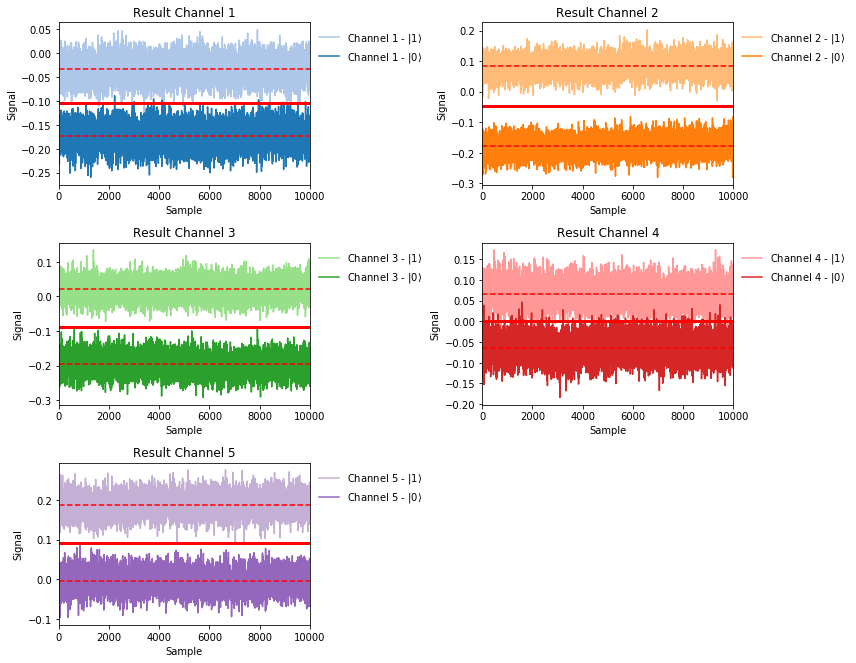

Channel 0: set threshold = -0.10332685546874999
Channel 1: set threshold = -0.04771240234375
Channel 2: set threshold = -0.087420703125
Channel 3: set threshold = 0.0013769531250000036
Channel 4: set threshold = 0.092464111328125


In [27]:
fig = plt.figure(figsize=[12, 15], tight_layout=True)

for ch in range(n_channels):
    result_ground = results_ground[ch]
    result_excited = results_excited[ch]
    trace_ground = list(result_ground.values())[ch]
    trace_excited = list(result_excited.values())[ch]
    color_ground = plt.cm.tab20(2*ch)
    color_excited = plt.cm.tab20(2*ch+1)
    
    ax = fig.add_subplot(n_channels,2,ch+1)
    ax.set_title(f'Result Channel {ch+1}')
    ax.plot(trace_excited, color=color_excited, label=r'Channel {} - $|{}\rangle$'.format(ch+1, 1))
    ax.plot(trace_ground, color=color_ground, label=r'Channel {} - $|{}\rangle$'.format(ch+1, 0))
    
    ax.axhline(np.mean(trace_ground), color='red', linestyle='--')
    ax.axhline(np.mean(trace_excited), color='red', linestyle='--')
    ax.axhline((np.mean(trace_ground)+np.mean(trace_excited))/2, color='red', linestyle='-', linewidth=3)
    ax.set_xlim([0, result_length])
    ax.set_xlabel('Sample')
    ax.set_ylabel('Signal')
    ax.legend(frameon=False, bbox_to_anchor=[1, 1])
plt.show()
    
thresholds = []
for ch in range(n_channels):
    result_ground = results_ground[ch]
    result_excited = results_excited[ch]
    trace_ground = list(result_ground.values())[ch]
    trace_excited = list(result_excited.values())[ch]
    thresholds.append((np.mean(trace_ground)+np.mean(trace_excited))/2)
    daq.setDouble(f'/{device}/qas/0/thresholds/{ch}/level', thresholds[ch])
    print(f'Channel {ch}: set threshold = {thresholds[ch]}')

## How good is the discriminator? <a class="anchor" id="discriminator-evaluation"></a>

Having defined the threshold for such a simple linear separator, we can use the previous measurement data in order to calculate readout fidelities of the individual channels. The probability of measuring the qubit in the excited state when it was initialized in the ground state can be calculated by taking the fraction of single shot measurements that are below the set threshold even though qubit was in its excited state. Accordingly, also the probability of finding a qubit in its ground state when it was set to be in the excited state can be calculated.

Below, we plot histograms of the normalized signals for qubits initialized in the ground (blue) and excited (red) states. The vertical black line indicates the separation threshold.

P(e|g) = 0.000
P(g|e) = 0.002


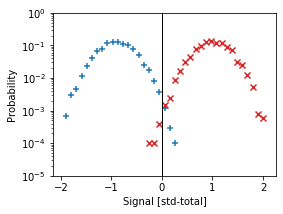

P(e|g) = 0.000
P(g|e) = 0.000


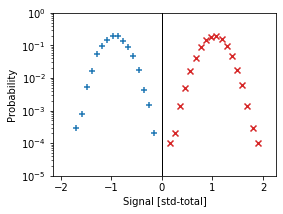

P(e|g) = 0.000
P(g|e) = 0.000


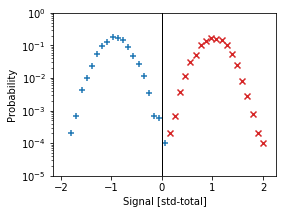

P(e|g) = 0.005
P(g|e) = 0.012


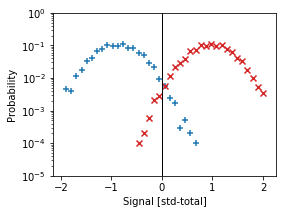

P(e|g) = 0.000
P(g|e) = 0.000


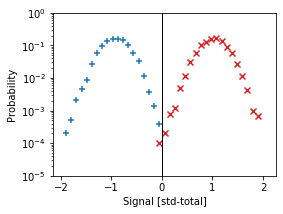

In [28]:
for ch in range(n_channels):
    result_ground = results_ground[ch]
    result_excited = results_excited[ch]
    trace_ground = list(result_ground.values())[ch] 
    trace_excited = list(result_excited.values())[ch]
    std_total = np.std(np.hstack([trace_ground, trace_excited]))
    
    trace_ground = np.array(trace_ground) - thresholds[ch]
    trace_excited = np.array(trace_excited) - thresholds[ch]
    
    fig, ax = plt.subplots(figsize=[4, 3])
    ax.set_yscale('log')
    ax.axvline(0, c='k', linewidth=1)
    
    bins = np.linspace(-2, 2, 40)
    hist_ground = np.histogram(trace_ground/std_total, bins=bins)
    ax.scatter(hist_ground[1][1:], hist_ground[0]/np.sum(hist_ground[0]), marker='+', color='tab:blue')
    hist_excited = np.histogram(trace_excited / std_total, bins=bins)
    ax.scatter(hist_excited[1][1:], hist_excited[0]/np.sum(hist_excited[0]), marker='x', color='tab:red')
    
    print('P(e|g) = {:.3f}'.format(np.sum(hist_ground[0][20:])/np.sum(hist_ground[0])))
    print('P(g|e) = {:.3f}'.format(np.sum(hist_excited[0][:20])/np.sum(hist_excited[0])))
    
    ax.set_ylim([1e-5, 1e0])
    ax.set_xlabel('Signal [std-total]')
    ax.set_ylabel('Probability')
    plt.show()

## Single-shot readout <a class="anchor" id="single-shot-readout"></a>

The thresholding feature of the QA now allows us to record the measurement data simply as binary values. The result `0` or `1` for each channel indicates if the corresponding qubit was measured in its ground ($|0>$) or excited ($|1>$) state. By averaging the result for each channel over all samples (`result_length`) we eventually obtain a state assignment probability. 

A true *single shot* measurement can be performed by setting both the sample length as well as the averages used for results to 1:
>```python
>result_length = 1
>result_averages = 1
>```

In [29]:
result_length = 1000
result_averages = 1

# set the data source of the results tab to after thresholding
set_qa_results(daq, device, result_length, result_averages, source='threshold')

# define ground state and arbitrary state to be measured
ground_state = [0] * n_channels
excited_state = [1, 0, 1, 0, 1]

result_paths = []
for ch in range(n_channels):
    result_paths.append(f'/{device}/qas/0/result/data/{ch}/wave')

result_list = []
# iterate over ground/excited state
for state in [ground_state, excited_state]: 
    print(f' - state: |{",".join(str(num) for num in state)}>')
    
    # set up AWG sequence program
    awg_program = sequence_multiplexed_readout(
        range(n_channels),  
        frequencies, 
        result_length*result_averages, 
        state=state
    )
    compile_sequence(awg, awg_program)

    # sync device, subscribe to path and run AWG
    daq.sync()
    time.sleep(0.1)
    daq.subscribe(result_paths)
    run_awg(daq, device)

    # poll data from DAQ
    result_list.append(acquisition_poll(daq, result_paths, result_length))
    print('\t\t--> Data acquired')
    daq.unsubscribe(result_paths)

result_ground = result_list[0]
result_excited = result_list[1]

# print and store final result for prepared state
measurement_result = []
print('\nNot Excited -------------------------')
for ch, result in enumerate(result_ground.values()):
    print(f'Channel {ch}:  is ( {np.mean(result)} )  \t- ( {0} )')
print('\nExcited -----------------------------')    
for ch, result in enumerate(result_excited.values()):
    measurement_result.append(np.mean(result))
    print(f'Channel {ch}:  is ( {np.mean(result)} )  \t- ( {excited_state[ch]} )')
    
measurement_result = np.array(measurement_result)
ground_state = np.array(ground_state)
excited_state = np.array(excited_state)

print(f'\nMeasurement result: {measurement_result}')
print(f'\nMeasurement error: \t{np.sum(np.abs(measurement_result - excited_state))}')

 - state: |0,0,0,0,0>
		--> Data acquired
 - state: |1,0,1,0,1>
		--> Data acquired

Not Excited -------------------------
Channel 0:  is ( 0.0 )  	- ( 0 )
Channel 1:  is ( 0.0 )  	- ( 0 )
Channel 2:  is ( 0.0 )  	- ( 0 )
Channel 3:  is ( 0.019 )  	- ( 0 )
Channel 4:  is ( 0.0 )  	- ( 0 )

Excited -----------------------------
Channel 0:  is ( 1.0 )  	- ( 1 )
Channel 1:  is ( 0.0 )  	- ( 0 )
Channel 2:  is ( 1.0 )  	- ( 1 )
Channel 3:  is ( 0.024 )  	- ( 0 )
Channel 4:  is ( 1.0 )  	- ( 1 )

Measurement result: [1.    0.    1.    0.024 1.   ]

Measurement error: 	0.024


## Cros-assignment <a class="anchor" id="cross-assignment"></a>

More generally, we now initialize the $n = $ `n_channels` qubits in all $2^n$ possible states and record the results for all qubits. This allows us to calculate the (cross-)assignment probabilities between all the possible states. 

**Careful!** Because of the exponentially increasing number of possible mulit-qubit states, the next cell will take very long to execute for many (n > 5) channels. 

The resulting assignment matrix is plotted in the next cell. It should ideally be all ones on the diagonal and zero everywhere else.

In [30]:
result_length = 1000
result_averages = 1

set_qa_results(daq, device, result_length, result_averages, source='threshold')

result_paths = []
for ch in range(n_channels):
    result_paths.append(f'/{device}/qas/0/result/data/{ch}/wave')

repeat = n_channels
combinations = list(itertools.product([0, 1], repeat=repeat))
if repeat < n_channels:
    new_combinations = []
    for c in combinations:
        new_combinations.append(np.hstack([np.zeros(n_channels-repeat), c]))
    combinations = new_combinations

result_list = []
for state in combinations:
    print(f' - state: |{",".join(str(num) for num in state)}>')
    
    # set up AWG sequence program
    awg_program = sequence_multiplexed_readout(
        range(n_channels),  
        frequencies, 
        result_length*result_averages, 
        state=state
    )
    compile_sequence(awg, awg_program)

    # ensure all settings are synced and substribe to data path(s)
    daq.sync()
    time.sleep(0.1)
    daq.subscribe(result_paths)

    # run AWG sequence and start acquisition
    run_awg(daq, device)

    # poll data
    result_list.append(acquisition_poll(daq, result_paths, result_length))
    print('\t\t--> Data acquired')
    daq.unsubscribe(result_paths)
    
print('\n*** Finished ***')

 - state: |0,0,0,0,0>
		--> Data acquired
 - state: |0,0,0,0,1>
		--> Data acquired
 - state: |0,0,0,1,0>
		--> Data acquired
 - state: |0,0,0,1,1>
		--> Data acquired
 - state: |0,0,1,0,0>
		--> Data acquired
 - state: |0,0,1,0,1>
		--> Data acquired
 - state: |0,0,1,1,0>
		--> Data acquired
 - state: |0,0,1,1,1>
		--> Data acquired
 - state: |0,1,0,0,0>
		--> Data acquired
 - state: |0,1,0,0,1>
		--> Data acquired
 - state: |0,1,0,1,0>
		--> Data acquired
 - state: |0,1,0,1,1>
		--> Data acquired
 - state: |0,1,1,0,0>
		--> Data acquired
 - state: |0,1,1,0,1>
		--> Data acquired
 - state: |0,1,1,1,0>
		--> Data acquired
 - state: |0,1,1,1,1>
		--> Data acquired
 - state: |1,0,0,0,0>
		--> Data acquired
 - state: |1,0,0,0,1>
		--> Data acquired
 - state: |1,0,0,1,0>
		--> Data acquired
 - state: |1,0,0,1,1>
		--> Data acquired
 - state: |1,0,1,0,0>
		--> Data acquired
 - state: |1,0,1,0,1>
		--> Data acquired
 - state: |1,0,1,1,0>
		--> Data acquired
 - state: |1,0,1,1,1>
		--> Data a

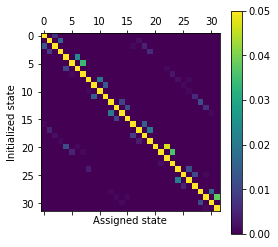

In [31]:
def assign_state(measurement):
    state = 0
    for m in measurement: 
        state = (state << 1) | m
    return state

####################


# assemble and plot the cross-assignment matrix
assignment_matrix = []
for comb, data_combination in enumerate(result_list):
    assigned_states = []
    for i in range(result_length):
        shot = []
        for data in list(data_combination.values()):
            shot.append(int(data[i]))
        assigned_states.append(assign_state(shot))
    h = np.histogram(assigned_states, bins=range(2**repeat+1))    
    assignment_matrix.append(h[0]) 
assignment_matrix = np.array(assignment_matrix) / result_length   


plt.matshow(assignment_matrix, vmax=0.05)
plt.colorbar()
plt.xlabel("Assigned state")
plt.ylabel("Initialized state")
plt.show()

This cross-ssignment matrix shows the probabiliy of assigning state $j$ (column) after initializing the multi-qubit state $i$ (row). The $2^n$ possible states are encoded in binary, s.t. $i=1$ corresponds to the state $|0, 0, ... , 1>$ . Ideally, the cross-assignment matrix corresponds to the identity matrix.